# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of Zalando's article images (Fashion MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods (both tasks)
*	1 pt: optimize hyperparameters using grid/random search and cross-validation (both tasks)
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import random 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, SequentialSampler, ConcatDataset
from torchvision import transforms
from torch.autograd import Variable
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm   
from scipy.stats import loguniform 
from IPython.display import clear_output
from torch import utils


The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respectively the input and the target (label).

In [ ]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 

--2022-09-09 10:29:40--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2022-09-09 10:29:43 (61.3 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2022-09-09 10:29:43--  https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regression_dataset/test_data.csv’

test_data.csv 

How to load the data:

In [ ]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

How to get a specific sample:

In [ ]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']

print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


All training points:

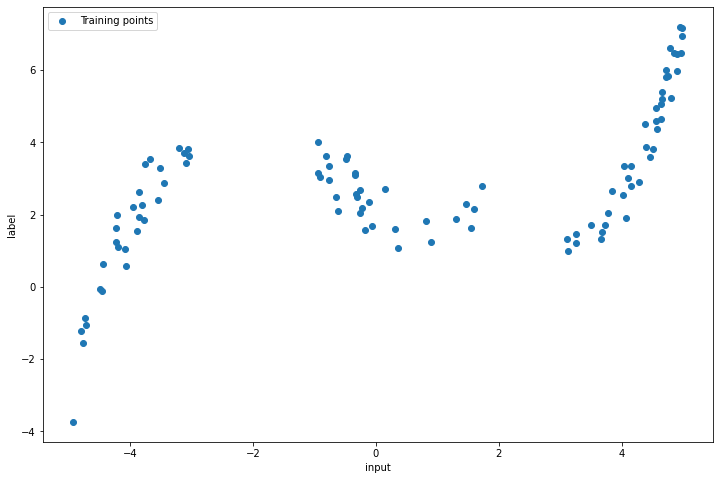

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.legend()
plt.show()

Define a network:

Fully connected feed-forward network with 2 hidden layers. It uses a sigmoid activation function. 

In [ ]:
class Network(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, dropout1 = 0, dropout2 = 0):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        dropout1 - probability of dropout in the 1st hidden layer
        dropout2 - probability of dropout in the 2nd hidden layer
        """
        super().__init__()
        
        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)

        self.act = nn.ReLU()

        self.dropout1 = nn.Dropout(p=dropout1)
        self.dropout2 = nn.Dropout(p=dropout2)
        
    def forward(self, x):
        x1 = self.act(self.fc1(x))
        x1 = self.dropout1(x1)

        x2 = self.act(self.fc2(x1))
        x2 = self.dropout2(x2)

        output = self.out(x2)
        return output


    def train_epoch(self, training_dataset, loss_fn, optimizer, device):
        self.train() # Training mode (e.g. enable dropout, batchnorm updates,...)

    ### TRAINING LOOP
        train_loss_log = []
        ### TRAIN
        train_loss= []
        for sample_batched in training_dataset:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            optimizer.zero_grad()

            # Forward pass
            out = self(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Backpropagation
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

        # Save average train loss
        train_loss = np.mean(train_loss)
        train_loss_log.append(train_loss)

        return train_loss_log

    def validate(self, validation_dataset, loss_fn, optimizer, device, verbose=True):
        self.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)

        ### VALIDATION
        val_loss= []
        val_loss_log = []

        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in validation_dataset:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                # Forward pass
                out = self(x_batch)

                # Compute loss
                loss = loss_fn(out, label_batch)

                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)
                
            
            # Save average validation loss
            val_loss = np.mean(val_loss)
            val_loss_log.append(val_loss) 

            #if verbose:
            #  print(f"Loss = {val_loss}")

        return val_loss_log 

    def fit(self, training_data, validation_data, loss_fn, params_dict, verbose=True):
      train_loss_means = []
      val_loss_means = []
      optimizer = params_dict.get('optimizer')
      device = params_dict.get('device')
      num_epochs = params_dict.get('num_epochs')

      for epoch_num in range(num_epochs):
        train_loss_mean = self.train_epoch(training_data, loss_fn, optimizer, device)
        train_loss_means.append(train_loss_mean)

        val_loss_mean = self.validate(validation_data, loss_fn, optimizer, device)
        val_loss_means.append(val_loss_mean)                
        if verbose:
          print("Epoch:", epoch_num, "Training loss:", train_loss_mean, "Validation loss:", val_loss_mean)
      return train_loss_means, val_loss_means

      

Define a dataset class. 

In [ ]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.data = pd.read_csv(csv_file)
        self.cols = list(self.data.columns)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample constitutes of two elements contained in a tuple:
        # first -> x value ('input')
        # second -> y value ('label')        
        sample = (self.data.iloc[idx][self.cols[0]], self.data.iloc[idx][self.cols[1]])
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

The first task is to separate the training dataset into training and validation sets. Validation points are randomly selected from the training points (~20% of training data).

In [ ]:
print("Length of training set:", len(train_df))
print("---------------------")

tot_points = len(train_df)
train_points = 0.8*tot_points
val_points = tot_points-train_points

print("Number of training points:", train_points)
print("Number of validation points:", val_points)
print("---------------------")

Length of training set: 100
---------------------
Number of training points: 80.0
Number of validation points: 20.0
---------------------


Run example network to check functionality. 

In [ ]:
composed_transform = transforms.Compose([ToTensor()])

test_dataset = CsvDataset('regression_dataset/test_data.csv', transform=composed_transform)
train_dataset= CsvDataset('regression_dataset/train_data.csv', transform=composed_transform)

In [ ]:
train_dataset, val_dataset = train_test_split(train_dataset, train_size=0.8, test_size=0.2, shuffle=True)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


In [ ]:
# Initialize the network
torch.manual_seed(0)

net = Network(Ni=1, Nh1=64, Nh2=128, No=1, dropout1=0.1, dropout2=0.2)
net.to(device)

Network initialized


Network(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
  (act): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [ ]:
# Define the loss function
loss_fn = nn.MSELoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3)

params = dict({'optimizer': optimizer,
               'num_epochs': 250,
               'device': device})

In [ ]:
train_loss_log, val_loss_log = net.fit(train_dataset, val_dataset, loss_fn, params, verbose=True)

Epoch: 0 Training loss: [4.0929785] Validation loss: [2.49937]
Epoch: 1 Training loss: [3.0409923] Validation loss: [2.1217086]
Epoch: 2 Training loss: [2.6807494] Validation loss: [2.2449608]
Epoch: 3 Training loss: [2.2438016] Validation loss: [1.9500144]
Epoch: 4 Training loss: [2.4799438] Validation loss: [2.0909095]
Epoch: 5 Training loss: [2.2998164] Validation loss: [1.8403203]
Epoch: 6 Training loss: [1.9730418] Validation loss: [1.7772434]
Epoch: 7 Training loss: [2.0840402] Validation loss: [1.7958391]
Epoch: 8 Training loss: [1.9778678] Validation loss: [1.9276069]
Epoch: 9 Training loss: [2.1523526] Validation loss: [1.7352318]
Epoch: 10 Training loss: [1.6669935] Validation loss: [1.9565823]
Epoch: 11 Training loss: [1.8452835] Validation loss: [1.6169608]
Epoch: 12 Training loss: [2.0807385] Validation loss: [1.6918863]
Epoch: 13 Training loss: [1.7257411] Validation loss: [1.6552856]
Epoch: 14 Training loss: [2.25225] Validation loss: [1.5297158]
Epoch: 15 Training loss:

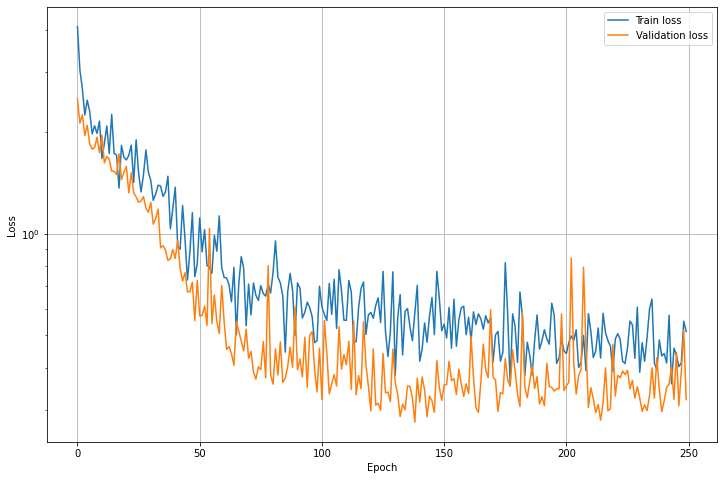

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
#Check values on test dataset
all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        out = net(x_batch)
        # Save outputs and labels
        all_inputs.append(x_batch)
        all_outputs.append(out)
        all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

AVERAGE TEST LOSS: 0.2644008994102478


In [ ]:
#plot the network output with the test data
# Input vector
x_vec = torch.linspace(-5,+5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
# eval() acts as switch for some specific layers/parts of the model that behave
# differently during training and inference (eval) time. For example, Dropout 
# BatchNorm etc. 
net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


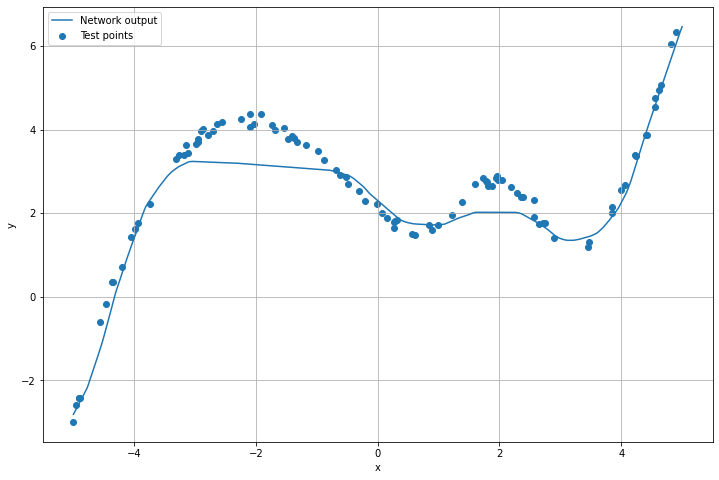

In [ ]:
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.scatter(test_df.input, test_df.label, label='Test points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

## Hold-out cross validation
To find the best hyperparameters we must impliment a parameter check - using hold-out cross-validation. 
Make a grid of the options for finding the best parameters. 
Use skorch library.

In [ ]:
#loop through sampled random networks and then gridsearch best lr & number epochs

parameters_dict = {
    'dropout1'   : np.random.uniform(0, 0.3, 100),
    'dropout2'   : np.random.uniform(0, 0.5, 100),
    'Nh1'        : [16,32,64],
    'Nh2'        : [32,64,96],
    'optimizer'  : ['adam', 'sgd'],
    'lr'         : [0.001, 0.002, 0.003, 0.004, 0.005],
    'n_epochs'   : [100, 200, 300],
    'w_decay'    : [0.001,0.01,0.1]
}
#sample a single set of parameters out
def sample_set_params(params_all):
  selection = {}
  for param in params_all.keys():
    selection[param] = np.random.choice(params_all.get(param) )

  return selection

In [ ]:
def get_correct_optimizer(model, params_dict):
    learn_r = params_dict.get('lr')
    w_decay = params_dict.get('w_decay')
    
    #instantiate the correct optimizer
    if params_dict.get('optimizer') == 'sgd':
        optimizer = optim.SGD(
            model.parameters(),
            lr = learn_r,
            weight_decay = w_decay
            )

    elif params_dict.get('optimizer') == 'adam':
        optimizer = optim.Adam(
        model.parameters(),
        lr = learn_r,
        weight_decay = w_decay
        )

    return optimizer

In [ ]:
# Define the loss function
loss_fn = nn.MSELoss()
# Ni & No don't change
Ni = 1
No = 1
iterations = 300
parameters_list = []
train_losses = []
val_losses = []

train_loss_avg = []
val_loss_avg = []

for iteration in range(iterations):
  #select a model
  actual_params = sample_set_params(parameters_dict)
  parameters_list.append(actual_params)

  Nh1 = actual_params.get('Nh1')
  Nh2 = actual_params.get('Nh2')
  dropout1 = actual_params.get('dropout1')
  dropout2 = actual_params.get('dropout2')
  n_epochs = actual_params.get('n_epochs')

  #instantiate new network
  net = Network(Ni, Nh1, Nh2, No, dropout1, dropout2).to(device)
  print("TRIAL NUMBER:", iteration)
  print("Nh1:", Nh1, "Nh2:", Nh2, "dropout1:", dropout1, "dropout2:", dropout2, "Num epochs:", n_epochs)
  # Define the optimizer
  optimizer = get_correct_optimizer(net, actual_params)

  params = dict({'optimizer': optimizer,
               'num_epochs': n_epochs,
               'device': device})

  train_loss_log, val_loss_log = net.fit(train_dataset, val_dataset, loss_fn, params, verbose=0)

  #print("loss_log", train_loss_log)
  train_losses.append(train_loss_log)
  #print("train losses",train_losses)
  
  val_losses.append(val_loss_log)
  #print("avg", np.mean(train_losses[-1]))
  train_loss_avg.append(np.mean(train_losses[-1]))
  #print("append avg:", train_loss_avg)
  print("Training loss:",np.mean(train_losses[-1]))
  val_loss_avg.append(np.mean(val_losses[-1]))  
  print("Validation loss:",np.mean(val_losses[-1]))

  print("################################")

Network initialized
TRIAL NUMBER: 0
Nh1: 16 Nh2: 96 dropout1: 0.06388843816449533 dropout2: 0.0665968886809844 Num epochs: 100
Training loss: 1.0783707
Validation loss: 0.9550962
################################
Network initialized
TRIAL NUMBER: 1
Nh1: 32 Nh2: 32 dropout1: 0.2521741618495735 dropout2: 0.1704271095044379 Num epochs: 100
Training loss: 2.2487588
Validation loss: 2.0545752
################################
Network initialized
TRIAL NUMBER: 2
Nh1: 16 Nh2: 32 dropout1: 0.2521741618495735 dropout2: 0.30681522240189546 Num epochs: 100
Training loss: 1.6190242
Validation loss: 1.4802675
################################
Network initialized
TRIAL NUMBER: 3
Nh1: 16 Nh2: 32 dropout1: 0.023676292110486163 dropout2: 0.00881385432254983 Num epochs: 300
Training loss: 0.6273924
Validation loss: 0.558586
################################
Network initialized
TRIAL NUMBER: 4
Nh1: 32 Nh2: 96 dropout1: 0.2706949639757387 dropout2: 0.4271192322965031 Num epochs: 200
Training loss: 1.2839758
V

In [ ]:
#find min validation loss value in list (best performer)
best_value = min(val_loss_avg)
print(best_value)
#find index of max value in list 
best_index = val_loss_avg.index(best_value)
best_set = parameters_list[best_index]

0.4978069


In [ ]:
best_set

{'dropout1': 0.01271287746848172,
 'dropout2': 0.13099058200414682,
 'Nh1': 32,
 'Nh2': 96,
 'optimizer': 'adam',
 'lr': 0.001,
 'n_epochs': 300,
 'w_decay': 0.001}

## Best network

In [ ]:
#train using best params
Nh1 = best_set.get('Nh1')
Nh2 = best_set.get('Nh2')
dropout1 = best_set.get('dropout1')
dropout2 = best_set.get('dropout2')
learn_r  = best_set.get('lr')
n_epochs = best_set.get('n_epochs')
w_decay = best_set.get('w_decay')

In [ ]:
best_net = Network(Ni, Nh1, Nh2, No, dropout1, dropout2)
best_net.to(device)

# Define the optimizer
optimizer = get_correct_optimizer(best_net, best_set)

params = dict({'optimizer': optimizer,
               'num_epochs': n_epochs,
               'device': device})

print(params)
train_loss_log, val_loss_log = best_net.fit(train_dataset, val_dataset, loss_fn, params, verbose=True)

Network initialized
{'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0.001
), 'num_epochs': 300, 'device': device(type='cpu')}
Epoch: 0 Training loss: [5.3817835] Validation loss: [2.618218]
Epoch: 1 Training loss: [3.1808608] Validation loss: [2.6663318]
Epoch: 2 Training loss: [3.1445713] Validation loss: [2.705558]
Epoch: 3 Training loss: [2.9012837] Validation loss: [2.3090816]
Epoch: 4 Training loss: [2.612285] Validation loss: [2.1959352]
Epoch: 5 Training loss: [2.2683702] Validation loss: [2.1653738]
Epoch: 6 Training loss: [2.3973272] Validation loss: [2.0979896]
Epoch: 7 Training loss: [2.3902607] Validation loss: [2.0481715]
Epoch: 8 Training loss: [1.9868714] Validation loss: [2.1317887]
Epoch: 9 Training loss: [2.0359313] Validation loss: [2.0586367]
Epoch: 10 Training loss: [2.4512951] Validation loss: [2.044208]
Epoch: 11 Training lo

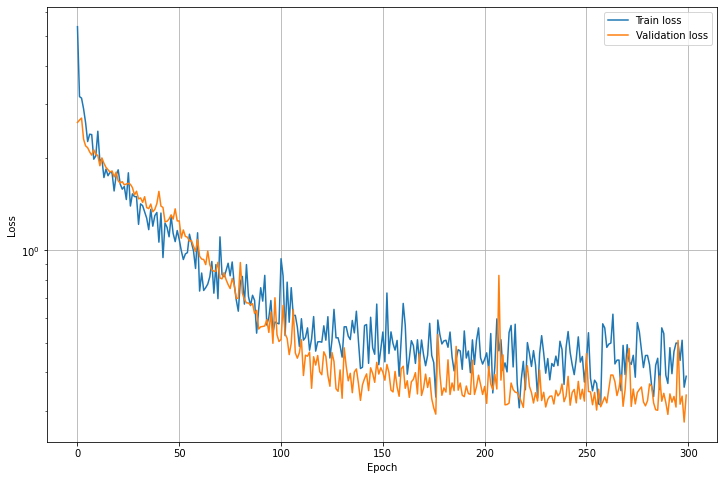

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
#Check values on test dataset
all_inputs = []
all_outputs = []
all_labels = []
best_net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        out = best_net(x_batch)
        # Save outputs and labels
        all_inputs.append(x_batch)
        all_outputs.append(out)
        all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

AVERAGE TEST LOSS: 0.280203253030777


In [ ]:
#plot the network output with the test data
# Input vector
x_vec = torch.linspace(-5,+5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
# eval() acts as switch for some specific layers/parts of the model that behave
# differently during training and inference (eval) time. For example, Dropout 
# BatchNorm etc. 
best_net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = best_net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

Input shape: torch.Size([1000, 1])
Output shape: torch.Size([1000, 1])


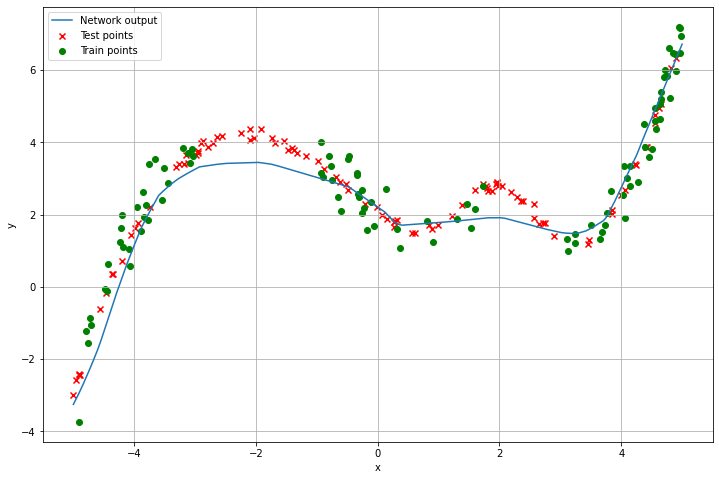

In [ ]:
# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.scatter(test_df.input, test_df.label, label='Test points', color="red", marker="x")
plt.scatter(train_df.input, train_df.label, label='Train points', color="green")
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

## Weights and activations

In [ ]:
# First hidden layer
h1_weight = best_net.fc1.weight.data.cpu().numpy()
h1_bias   = best_net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_weight = best_net.fc2.weight.data.cpu().numpy()
h2_bias   = best_net.fc2.bias.data.cpu().numpy()

# Output layer
out_weight = best_net.out.weight.data.cpu().numpy()
out_bias   = best_net.out.bias.data.cpu().numpy()

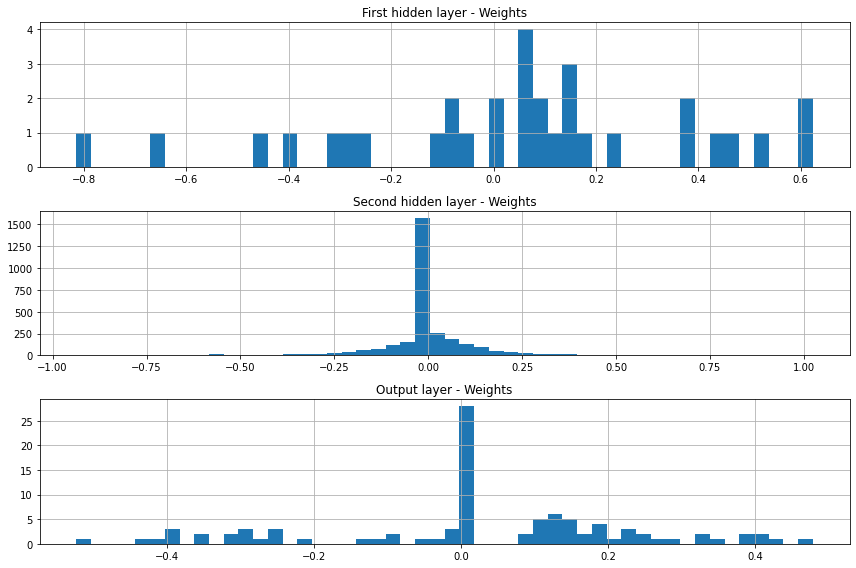

In [ ]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_weight.flatten(), 50)
axs[0].set_title('First hidden layer - Weights')

axs[1].hist(h2_weight.flatten(), 50)
axs[1].set_title('Second hidden layer - Weights')

axs[2].hist(out_weight.flatten(), 50)
axs[2].set_title('Output layer - Weights')
[ax.grid() for ax in axs]
#plt.savefig('weights.png')
plt.tight_layout()
plt.show()

Activations

In [ ]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

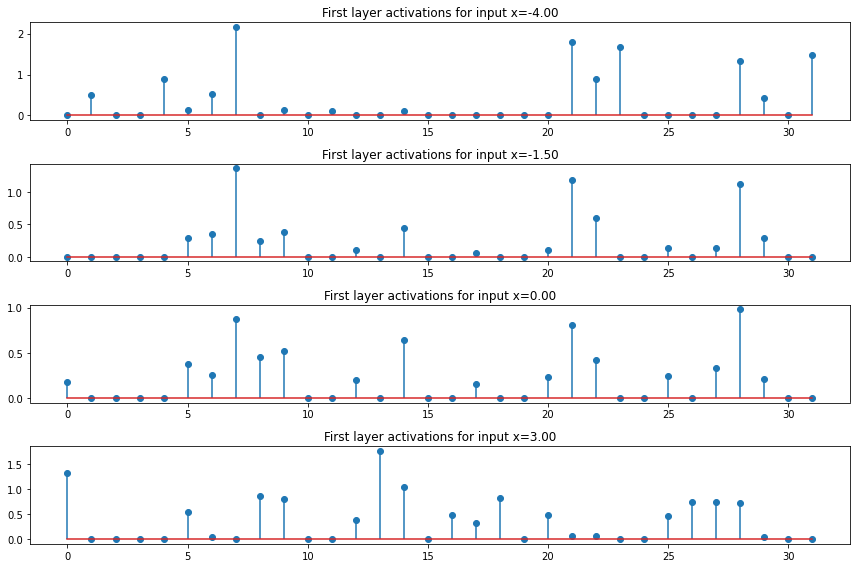

In [ ]:
### Register hook  
hook_handle1 = best_net.fc1.register_forward_hook(get_activation)

### Analyze activations
best_net.to(device).eval()
inputs = [-4, -1.5, 0, 3]
inputs_list = [ torch.tensor([x]).float() for x in inputs]
outputs_list = []

with torch.no_grad():
    for input in inputs_list:
        temp_y = best_net(input.to(device))
        outputs_list.append(activation)

### Remove hook
hook_handle1.remove()

### Plot activations
tot_inputs = len(inputs_list)
fig, axs = plt.subplots(tot_inputs, 1, figsize=(12,8))
for i, output in enumerate(outputs_list): 
    axs[i].stem(output.cpu().numpy(), use_line_collection=True)
    axs[i].set_title('First layer activations for input x=%.2f' % inputs[i])
#plt.savefig('activations_first.png')
plt.tight_layout()
plt.show()

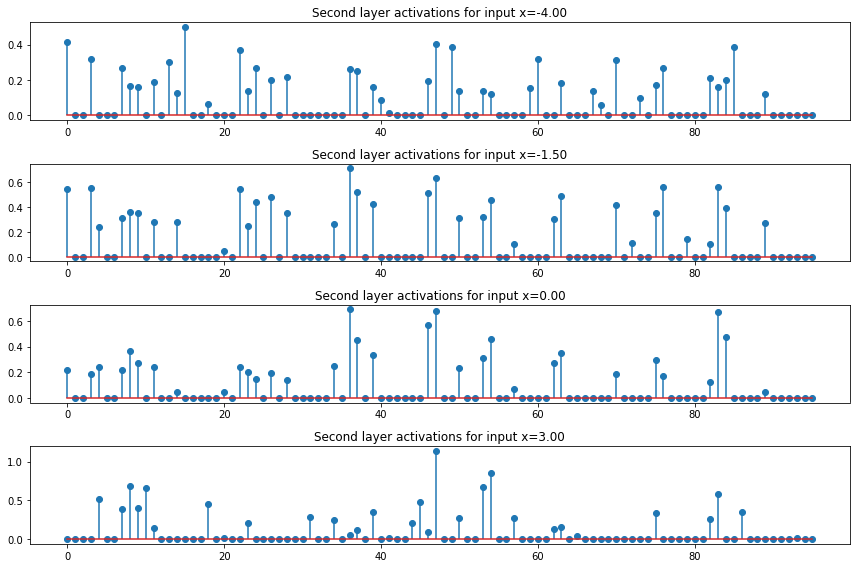

In [ ]:
### Register hook  
hook_handle1 = best_net.fc2.register_forward_hook(get_activation)

### Analyze activations
best_net.to(device).eval()
inputs = [-4, -1.5, 0, 3]
inputs_list = [ torch.tensor([x]).float() for x in inputs]
outputs_list = []

with torch.no_grad():
    for input in inputs_list:
        temp_y = best_net(input.to(device))
        outputs_list.append(activation)

### Remove hook
hook_handle1.remove()

### Plot activations
tot_inputs = len(inputs_list)
fig, axs = plt.subplots(tot_inputs, 1, figsize=(12,8))
for i, output in enumerate(outputs_list): 
    axs[i].stem(output.cpu().numpy(), use_line_collection=True)
    axs[i].set_title('Second layer activations for input x=%.2f' % inputs[i])
#plt.savefig('activations_first.png')
plt.tight_layout()
plt.show()

# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

Download the dataset:

In [ ]:
training_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

How to get an image and the corresponding label:

SAMPLE AT INDEX 0
LABEL: 9


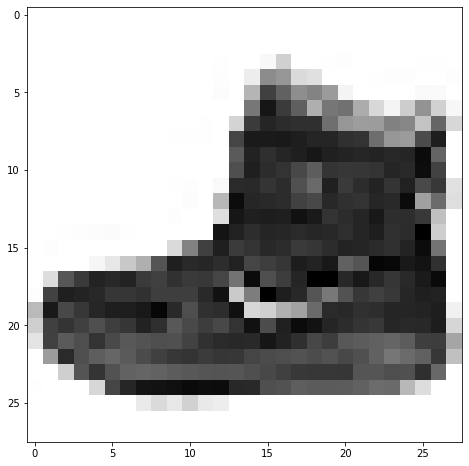

In [ ]:
sample_index = 0
image = training_dataset[sample_index][0]
label = training_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [ ]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [ ]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


Number of labels: 10


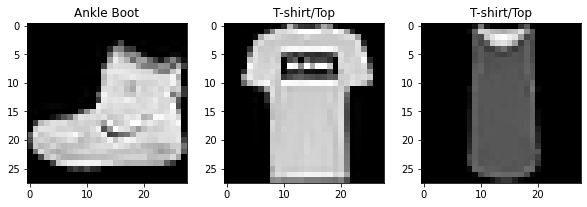

In [ ]:
print("Number of labels:", len(torch.unique(test_dataset.targets)))
lab_dict = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}
#plot first 3 images with label
plt.figure(figsize = (10,10))
for i in range(3):
  plt.subplot(330+1+i)
  plt.imshow(training_dataset[i][0], cmap = "gist_gray")
  plt.title(lab_dict[training_dataset[i][1]])
plt.show()

In [ ]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        image, label = sample
        return (torchvision.transforms.ToTensor(image).float(),
                torch.Tensor([label]).float())

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
# Set the train transform
training_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [ ]:
#split training dataset into training and validation sets (80:20 split)
print("Length of training set:", len(training_dataset))
print("---------------------")

tot_points = len(training_dataset)
train_points = 0.8*tot_points
val_points = tot_points-train_points

print("Number of training points:", train_points)
print("Number of validation points:", val_points)
print("---------------------")

Length of training set: 60000
---------------------
Number of training points: 48000.0
Number of validation points: 12000.0
---------------------


In [ ]:
train_dataset, validation_dataset = torch.utils.data.random_split(training_dataset, [int(train_points), int(val_points)])
batch_size = 300

train_dataloader = DataLoader(train_dataset,batch_size = batch_size,shuffle = True,num_workers = 0)
val_dataloader = DataLoader(validation_dataset,batch_size = batch_size,shuffle = False,num_workers = 0)
test_dataloader = DataLoader(test_dataset,batch_size = batch_size,shuffle = False, num_workers = 0)

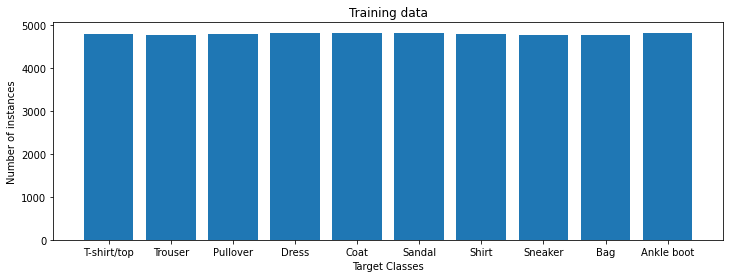

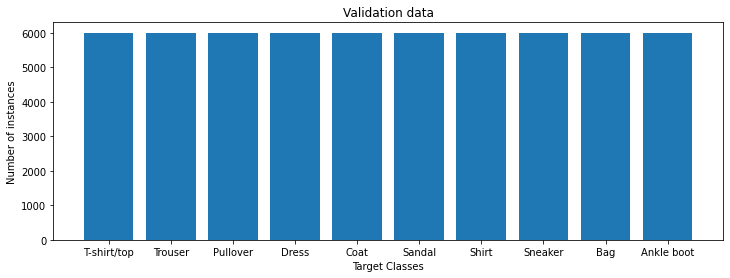

In [ ]:
#Iterating over the training dataset and storing the target class for each sample
classes = []
dataloaders = [train_dataloader, val_dataloader]
titles = ["Training data", "Validation data"]

for i in range(len(dataloaders)):
  for batch_idx, data in enumerate(dataloaders[i], 0):
      x, y = data 
      classes.extend(y.tolist())
        
  #Calculating the unique classes and the respective counts and plotting them
  unique, counts = np.unique(classes, return_counts=True)
  names = list(test_dataset.class_to_idx.keys())

  fig = plt.figure(figsize=(12,4))
  plt.bar(names, counts)
  plt.title(titles[i])
  plt.xlabel("Target Classes")
  plt.ylabel("Number of instances")
  plt.show()



## CNN

In [ ]:
class ConvNetwork(nn.Module):
    
    def __init__(self, n_channels, dropout):
        """
        - 1st convolutional layer - 1 input channel, n_channels output channels, 3x3 kernel
        - 2nd convolutional layer - n_channels input, 2*n_channels output, 3x3
        - dropout layer
        - fully connected layer (image size)*(2*n_channels) inputs, 100 outputs
        - fully connected layer 100 inputs, 10 outputs 

        inputs:
        n_channels = number of conv channels
        dropout = dropout probability in dropout layer

        """
        super().__init__()
        
        print('Network initialized')
        #image size input = 28 x 28
        self.conv1 = nn.Conv2d(1, n_channels, kernel_size=5)
        #image size - 28 -5 + 1 = 24 x 24
        self.mpool = nn.MaxPool2d(2,2)
        #maxpooling 1/2 size = 12 x 12
        self.conv2 = nn.Conv2d(n_channels, 2*n_channels, kernel_size=3)
        #image size = 12-3 + 1 = 10 x 10
        self.drop1 = nn.Dropout(p=dropout)
        #max pooling = 5 x 5
        #80*25 and 200*100
        #input = image size * 2*n_channels = 5*5*2 = 50
        #50*n_channels
        self.fc1 = nn.Linear((50*n_channels), 100)
        self.fc2 = nn.Linear(100,10)

        self.act = nn.ReLU()

        
    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.mpool(x)
        x = self.act(self.conv2(x))
        x = self.mpool(x)

        x = self.drop1(x)
        #print(x.shape)
        x = x.view(x.size(0), -1) # reshaping necessary for linear layer
        #print(x.shape)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))

        #output = self.out(x)
        return x


    def train_epoch(self, training_dataset, loss_fn, optimizer, device):
        self.train() # Training mode (e.g. enable dropout, batchnorm updates,...)

    ### TRAINING LOOP
        train_loss_log = []
        ### TRAIN
        train_loss= []
        for sample_batched in training_dataset:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            optimizer.zero_grad()

            # Forward pass
            out = self(x_batch)

            # Compute loss
            loss = loss_fn(out, label_batch)

            # Backpropagation
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)

        # Save average train loss
        train_loss = np.mean(train_loss)
        train_loss_log.append(train_loss)

        return train_loss_log

    def validate(self, validation_dataset, loss_fn, optimizer, device, verbose=True):
        self.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)

        ### VALIDATION
        val_loss= []
        val_loss_log = []

        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in validation_dataset:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                # Forward pass
                out = self(x_batch)

                # Compute loss
                loss = loss_fn(out, label_batch)

                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)
                
            
            # Save average validation loss
            val_loss = np.mean(val_loss)
            val_loss_log.append(val_loss) 

            #if verbose:
            #  print(f"Loss = {val_loss}")

        return val_loss_log 

    def fit(self, training_data, validation_data, loss_fn, params_dict, verbose=True):
      train_loss_means = []
      val_loss_means = []
      optimizer = params_dict.get('optimizer')
      device = params_dict.get('device')
      num_epochs = params_dict.get('num_epochs')

      for epoch_num in range(num_epochs):
        train_loss_mean = self.train_epoch(training_data, loss_fn, optimizer, device)
        train_loss_means.append(train_loss_mean)

        val_loss_mean = self.validate(validation_data, loss_fn, optimizer, device)
        val_loss_means.append(val_loss_mean)                
        if verbose:
          print("Epoch:", epoch_num, "Training loss:", train_loss_mean, "Validation loss:", val_loss_mean)
      return train_loss_means, val_loss_means

      

Check if CNN works on a test network. 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize the network
torch.manual_seed(0)

n_channels = 4
dropout = 0.1

net = ConvNetwork(n_channels, dropout)
net.to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss() 

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-2)


params = dict({'optimizer': optimizer,
               'num_epochs': 25,
               'device': device})


Network initialized


In [ ]:
train_loss_log, val_loss_log = net.fit(train_dataloader, val_dataloader, loss_fn, params, verbose=True)

KeyboardInterrupt: ignored

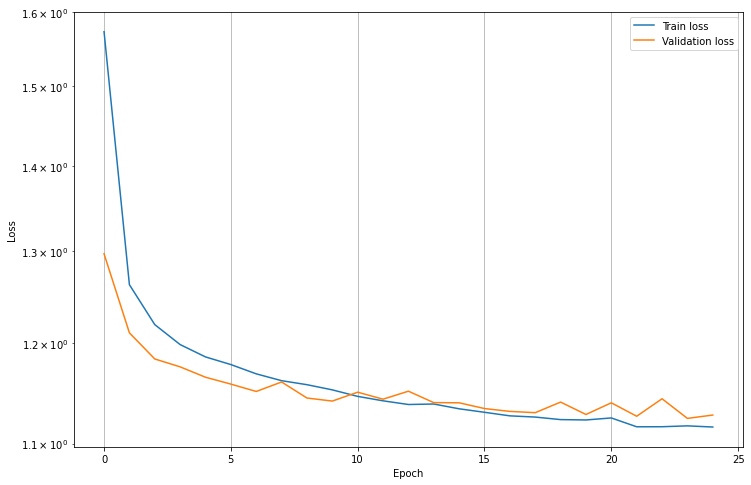

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Random search

It works. 
Now we will define a function for selecting a random network from a dictionary of parameters and then run training and validation to find the best network. 

In [ ]:
#loop through sampled randomly selected networks 

parameters_dict = {
    'dropout'    : np.random.uniform(0, 0.3, 100),
    'n_channels' : [3,4,5,6,7,8,9,10],
    'optimizer'  : ['adam', 'sgd'],
    'lr'         : [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01],
    'n_epochs'   : [40],
    'w_decay'    : [0.001,0.01,0.1]
}
#sample a single set of parameters out
def sample_set_params(params_all):
  selection = {}
  for param in params_all.keys():
    selection[param] = np.random.choice(params_all.get(param) )

  return selection

sample = sample_set_params(parameters_dict)
sample

{'dropout': 0.12190406424483624,
 'n_channels': 4,
 'optimizer': 'sgd',
 'lr': 1e-05,
 'n_epochs': 40,
 'w_decay': 0.001}

In [ ]:
#the training over the entire training dataset will take 7+ hours so I have split instead the validation set into training and a smaller validation set so that
#the training time is reduced. 
train_points=9500
val_points=2500
train_dataset_small, validation_dataset_small = torch.utils.data.random_split(validation_dataset, [int(train_points), int(val_points)])
batch_size = 100

train_dataloader_small = DataLoader(train_dataset_small,batch_size = batch_size,shuffle = True,num_workers = 0)
val_dataloader_small = DataLoader(validation_dataset_small,batch_size = batch_size,shuffle = False,num_workers = 0)

In [ ]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

iterations = 50
parameters_list = []

train_losses_final = []
val_losses_final = []

train_loss_avg = []
val_loss_avg = []

for iteration in range(iterations):
  train_losses = []
  val_losses = []

  #select a model
  actual_params = sample_set_params(parameters_dict)
  parameters_list.append(actual_params)

  n_channels = actual_params.get('n_channels')
  dropout = actual_params.get('dropout')
  n_epochs = actual_params.get('n_epochs')

  #instantiate new network
  net = ConvNetwork(n_channels, dropout)
  net.to(device)
  print("TRIAL NUMBER:", iteration)
  print("n_channels:", n_channels, "dropout perc:", dropout, "Num epochs:", n_epochs)
  # Define the optimizer
  optimizer = get_correct_optimizer(net, actual_params)

  params = dict({'optimizer': optimizer,
               'num_epochs': n_epochs,
               'device': device})

  train_loss_log, val_loss_log = net.fit(train_dataloader_small, val_dataloader_small, loss_fn, params, verbose=0)

  train_losses.append(train_loss_log) #all losses for each iteration
  val_losses.append(val_loss_log)

  train_losses_final.append(train_loss_log[-1]) #only final loss on final iteration
  val_losses_final.append(val_loss_log[-1])

  train_loss_avg.append(np.mean(train_losses[-1])) #average loss for whole iteration
  print("Training loss mean:",np.mean(train_losses[-1]), "Final loss:", train_losses_final[-1])
  val_loss_avg.append(np.mean(val_losses[-1]))  
  print("Validation loss mean:",np.mean(val_losses[-1]), "Final loss:", val_losses_final[-1])

  print("################################")

Network initialized
TRIAL NUMBER: 0
n_channels: 6 dropout perc: 0.2513130131750355 Num epochs: 40
Training loss mean: 0.7411317 Final loss: [0.33566877]
Validation loss mean: 0.7295558 Final loss: [0.3679831]
################################
Network initialized
TRIAL NUMBER: 1
n_channels: 6 dropout perc: 0.03669158770468801 Num epochs: 40
Training loss mean: 2.3008218 Final loss: [2.3008256]
Validation loss mean: 2.3012652 Final loss: [2.3014982]
################################
Network initialized
TRIAL NUMBER: 2
n_channels: 6 dropout perc: 0.26058760223851213 Num epochs: 40
Training loss mean: 0.6332344 Final loss: [0.486431]
Validation loss mean: 0.6004816 Final loss: [0.4637265]
################################
Network initialized
TRIAL NUMBER: 3
n_channels: 10 dropout perc: 0.2533314967434479 Num epochs: 40
Training loss mean: 0.7604846 Final loss: [0.25890744]
Validation loss mean: 0.7992326 Final loss: [0.3322336]
################################
Network initialized
TRIAL NUMBER

Select the best network by choosing the one with the minimum average validation loss.

In [ ]:
#find min validation loss value in list (best performer)
best_value = min(val_loss_avg)
#find index of max value in list 
best_index = val_loss_avg.index(best_value)
#print(best_index)
best_set = parameters_list[best_index]

In [ ]:
best_set

{'dropout': 0.13352469619361892,
 'n_channels': 5,
 'optimizer': 'adam',
 'lr': 0.005,
 'n_epochs': 40,
 'w_decay': 0.01}

## Best network

Train the best network and then test it on the test set.

In [ ]:
n_channels = best_set.get('n_channels')
dropout = best_set.get('dropout')
n_epochs = best_set.get('n_epochs')


best_net = ConvNetwork(n_channels, dropout)
best_net.to(device)

# Define the optimizer
optimizer = get_correct_optimizer(best_net, best_set)

params = dict({'optimizer': optimizer,
               'num_epochs': 100,
               'device': device})

print(params)
best_train_loss, best_val_loss = best_net.fit(train_dataloader, val_dataloader, loss_fn, params, verbose=True)

Network initialized
{'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.005
    maximize: False
    weight_decay: 0.01
), 'num_epochs': 100, 'device': 'cpu'}
Epoch: 0 Training loss: [1.3876038] Validation loss: [1.0599802]
Epoch: 1 Training loss: [0.72860813] Validation loss: [0.56938446]
Epoch: 2 Training loss: [0.5560788] Validation loss: [0.5238136]
Epoch: 3 Training loss: [0.53555477] Validation loss: [0.5003821]
Epoch: 4 Training loss: [0.5162827] Validation loss: [0.46608242]
Epoch: 5 Training loss: [0.49474496] Validation loss: [0.4543764]
Epoch: 6 Training loss: [0.48710695] Validation loss: [0.4775959]
Epoch: 7 Training loss: [0.4809071] Validation loss: [0.4480849]
Epoch: 8 Training loss: [0.47557658] Validation loss: [0.47593054]
Epoch: 9 Training loss: [0.46845403] Validation loss: [0.42772928]
Epoch: 10 Training loss: [0.46960336] Validation loss: [0.44773954]
Epoch: 11 Training 

In [ ]:
all_inputs = []
all_outputs = []
all_labels = []
best_net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        out = best_net(x_batch)
        # Save outputs and labels
        all_inputs.append(x_batch)
        all_outputs.append(out)
        all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

AVERAGE TEST LOSS: 0.41880619525909424


In [ ]:
#find index of the largest value in each output - this is the predicted label
pred_label = torch.argmax(all_outputs, dim=1, keepdims=True)

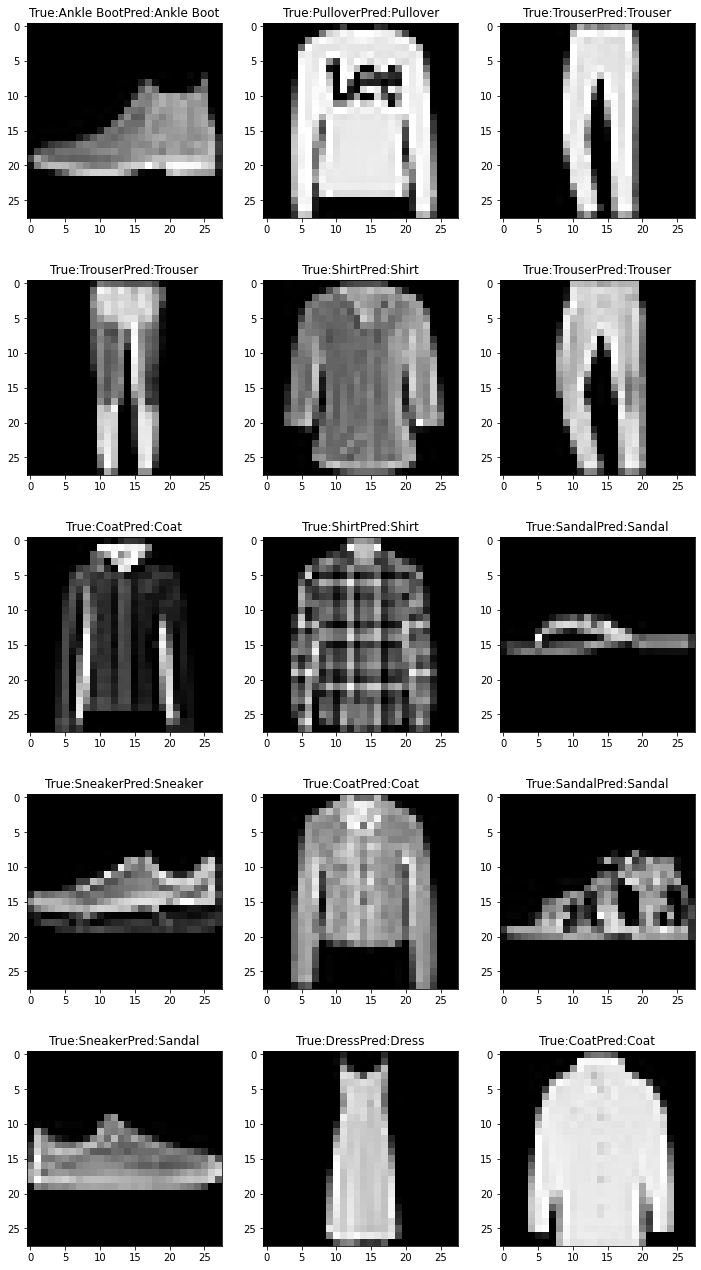

In [ ]:
#plot first 9 images with label
fig, axes = plt.subplots(nrows=5, ncols=3, figsize = (10,18))#, sharex='all', sharey='all')
fig.tight_layout()
image, label = next(iter(test_dataloader))
for i, ax in enumerate(axes.flatten()):
  #plt.subplot(330+1+i)
  #ax.imshow(training_dataset[i][0])

  ax.imshow(np.squeeze(image[i].permute(1,2,0), axis = 2), cmap="gray")
  ax.set_title("True:" + lab_dict[label[i].item()] + "Pred:"+ lab_dict[pred_label[i].item()])
#plt.title()
plt.show()

In [ ]:
pred_label = pred_label.reshape(1,len(pred_label))

In [ ]:
tot_correct_out = (pred_label == all_labels).sum()
test_accuracy = 100 * tot_correct_out / len(all_labels)
print(f"TEST ACCURACY: {test_accuracy:.2f}%")

TEST ACCURACY: 85.41%


## Weights and activations

Convolutional layers

In [ ]:
conv1_weights = best_net.conv1.weight.data.cpu().numpy()
conv2_weights = best_net.conv2.weight.data.cpu().numpy()

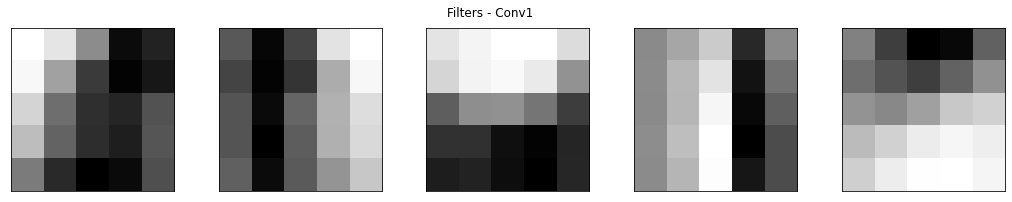

In [ ]:
fig, ax = plt.subplots(1,int(best_set['n_channels']), figsize=(18, 3))

for i in range(int(best_set['n_channels'])):
    ax[i].imshow( conv1_weights[i, 0, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.suptitle('Filters - Conv1 ', fontsize = 12)
#plt.savefig('filters_CL1_1.png')
plt.show()

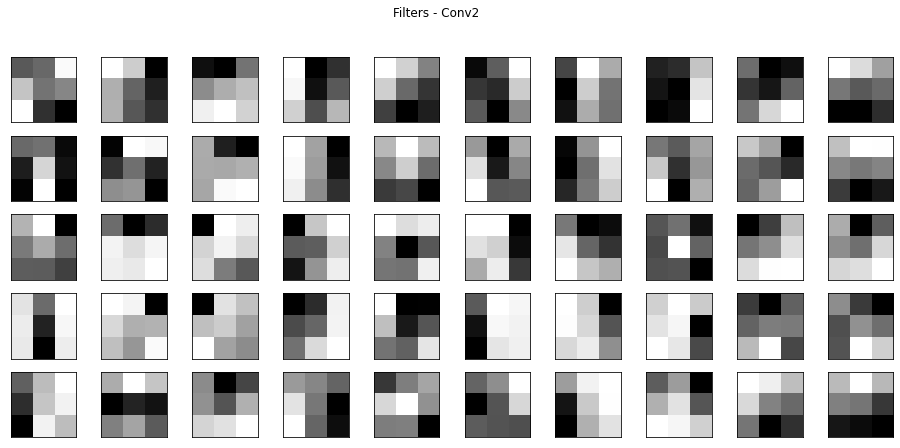

In [ ]:
fig, ax = plt.subplots(int(best_set['n_channels']), 2*int(best_set['n_channels']), figsize=(16, 7))

for i in range(int(best_set['n_channels'])):
    for j in range(2*int(best_set['n_channels'])):
        ax[i,j].imshow( conv2_weights[j, i, :,:], cmap='Greys')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
    
fig.suptitle('Filters - Conv2 ', fontsize = 12)
#plt.savefig('filters_CL1_2.png')
plt.show()

Fully connected layers

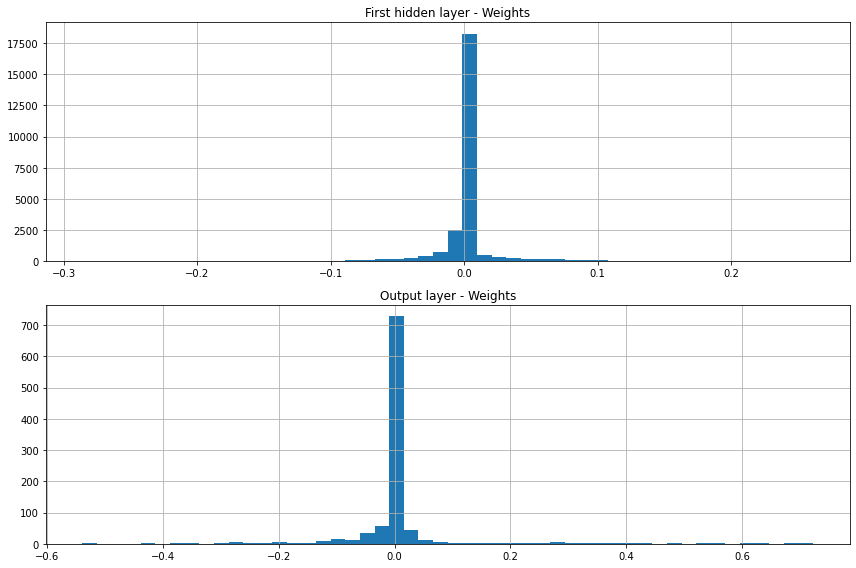

In [ ]:
# First hidden layer
h1_weight = best_net.fc1.weight.data.cpu().numpy()
h1_bias   = best_net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_weight = best_net.fc2.weight.data.cpu().numpy()
h2_bias   = best_net.fc2.bias.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(2, 1, figsize=(12,8))
axs[0].hist(h1_weight.flatten(), 50)
axs[0].set_title('First hidden layer - Weights')

axs[1].hist(h2_weight.flatten(), 50)
axs[1].set_title('Output layer - Weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

Activations

In [ ]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

In [ ]:
### Register hook  
hook_handle = best_net.conv1.register_forward_hook(get_activation)

### Analyze activations
net = best_net.to(device)
net.eval()

with torch.no_grad():
    for s_batch in test_dataloader:
        # Move data to device
        x1 = s_batch[0].to(device)
        # Forward pass
        y1 = best_net(x1)
        z1 = activation

### Remove hook
hook_handle.remove()

act1 = z1.cpu().numpy()
print(act1.shape)

(100, 5, 24, 24)


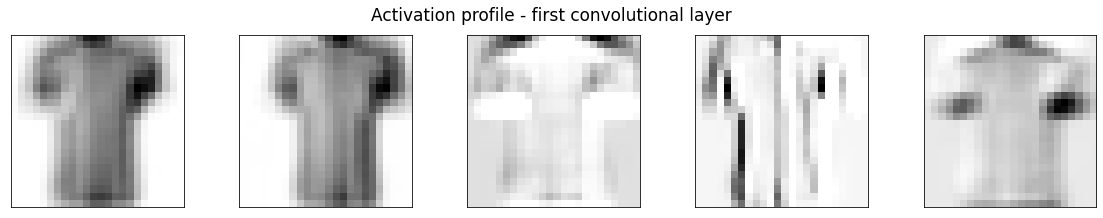

In [ ]:
## Plot activations
fig, ax = plt.subplots(1, int(best_set['n_channels']), figsize=(16,3))
plt.suptitle('Activation profile - first convolutional layer', fontsize=17)

for i in range(int(best_set['n_channels'])):
    ax[i].imshow(act1[0, i, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

    
plt.tight_layout()
plt.subplots_adjust(top=0.85)

#plt.savefig('activation_CL1.png')
plt.show()  

In [ ]:
### Register hook  
hook_handle = best_net.conv2.register_forward_hook(get_activation)

### Analyze activations
net = best_net.to(device)
net.eval()

with torch.no_grad():
    for s_batch in test_dataloader:
        # Move data to device
        x2 = s_batch[0].to(device)
        # Forward pass
        y2 = best_net(x2)
        z2 = activation

### Remove hook
hook_handle.remove()

act2 = z2.cpu().numpy()
print(act2.shape)

(100, 10, 10, 10)


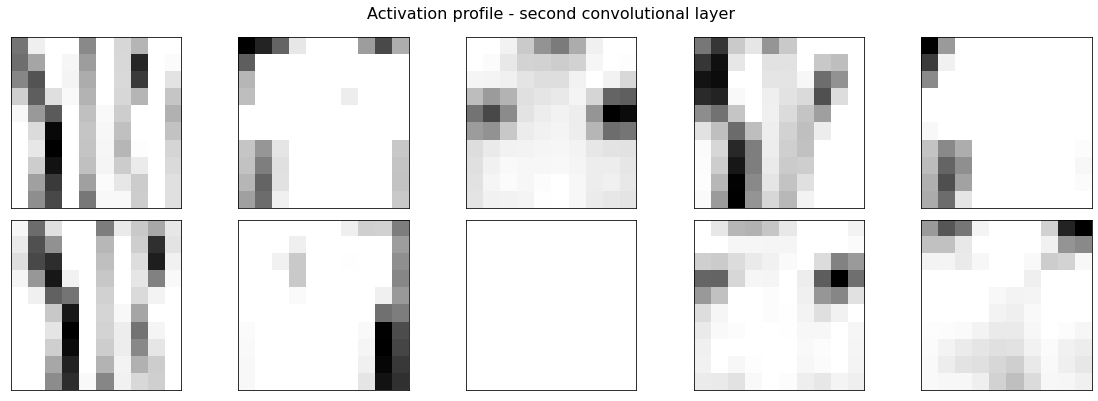

In [ ]:
## Plot activations
fig, ax = plt.subplots(2, int(best_set['n_channels']), figsize=(16,6))
fig.suptitle('Activation profile - second convolutional layer', fontsize=16, y = 0.92)    

for i in range(int(best_set['n_channels'])):
    ax[0, i].imshow( act2[0, i, :, :], cmap='Greys')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].imshow( act2[0, i+int(best_set['n_channels']), :, :], cmap='Greys')
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

plt.tight_layout()
plt.subplots_adjust(top=0.85)

#plt.savefig('activation_CL2.png')
plt.show()   